# Missing Value Treatment and One Hot Encoding

Im zweiten Abschnitt des Feature Engineerings wird der Datensatz weiter behandelt. Indem wir "Preis" als unsere endogene Variable festlegen, werden wir versuchen, es. Anschließend wird die Datenbereinigung durchgeführt, indem wir fehlende Werte behandeln und One-Hot-Encoding anwenden.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("Zwischenspeicher_Cars_Data.csv", sep=";")


In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91398 entries, 0 to 91397
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     91398 non-null  int64  
 1   url                            91398 non-null  object 
 2   Date                           91398 non-null  object 
 3   Country                        91398 non-null  object 
 4   Marke                          91398 non-null  object 
 5   Modell                         91398 non-null  object 
 6   Ort                            91398 non-null  object 
 7   Preis                          91398 non-null  float64
 8   Fahrzeugart                    91398 non-null  object 
 9   Karosserieform                 91398 non-null  object 
 10  Leistung                       91288 non-null  object 
 11  Kilometerstand                 91197 non-null  object 
 12  Fahrleistung p.a.              90847 non-null 

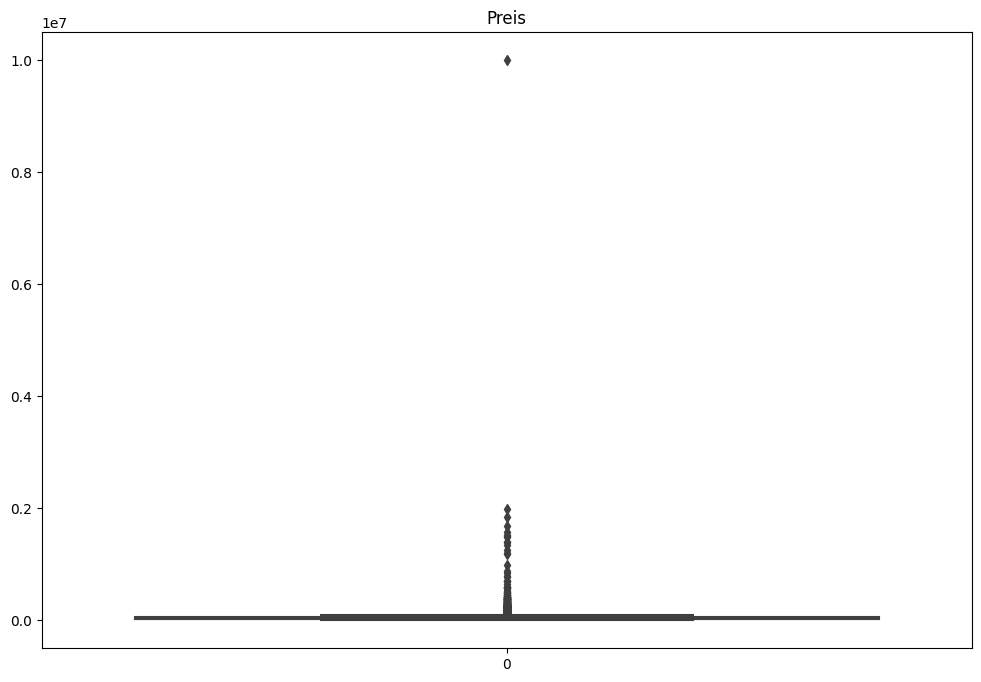

In [3]:
# plot Preis as histogram
plt.figure(figsize=(12, 8))
sns.boxplot(cars['Preis'])
plt.title('Preis')
plt.show()

Eine deutliche Schiefe ist erkennbar, wir sollten die Daten normalisieren beim Trainieren des Modells.

In [4]:
cars.Country.value_counts()

Deutschland    91398
Name: Country, dtype: int64

In [5]:
print(f"{cars.Marke.value_counts()}\n{cars.Marke.count()}")

mercedes-benz    28847
bmw              19861
volkswagen       18547
audi             11853
opel              8315
porsche           3975
Name: Marke, dtype: int64
91398


In [6]:
print(f"{cars.Antriebsart.value_counts()}\n{cars.Antriebsart.count()}")

Allrad    32386
Front     16003
Heck       9427
Name: Antriebsart, dtype: int64
57816


In [7]:
cars["Taxi oder Mietwagen"].value_counts()

Ja    1865
Name: Taxi oder Mietwagen, dtype: int64

In [8]:
cars["Sitzplätze"].count()

87969

Spalten löschen

In [10]:
# Drop (hauptsächlich aufgrund von zu vielen NaN-Samples)


selected_columns = ['Energieeffizienzklasse', 'Baujahr', 'CO₂-Emissionen (WLTP)2',
                     'Kraftstoffverbrauch (WLTP)2', 'Letzte Inspektion',
                     'Elektrische Reichweite (WLTP)', 'CO₂-Emissionen2',
                     'Antriebsart', 'Leergewicht', 'Zylinder', 'Länderversion',
                     'Gänge', 'Fahrzeughalter', 'Kraftstoff', 'Sitzplätze',
                     'Unnamed: 0', 'url', 'Date', 'Country', "Kraftstoffverbrauch2", "Umweltplakette"]


cars = cars.drop(selected_columns, axis=1)


In [11]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91398 entries, 0 to 91397
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Marke                       91398 non-null  object 
 1   Modell                      91398 non-null  object 
 2   Ort                         91398 non-null  object 
 3   Preis                       91398 non-null  float64
 4   Fahrzeugart                 91398 non-null  object 
 5   Karosserieform              91398 non-null  object 
 6   Leistung                    91288 non-null  object 
 7   Kilometerstand              91197 non-null  object 
 8   Fahrleistung p.a.           90847 non-null  object 
 9   Getriebe                    90721 non-null  object 
 10  Türen                       90150 non-null  float64
 11  Außenfarbe                  89731 non-null  object 
 12  Komfort                     89268 non-null  object 
 13  Sicherheit                  887

Anpassen der Features (Daten anpassen für Streamlit Data Explorer)

In [12]:
# Preparing Dataset for Data Exploration on Streamlit (Fix qualitative data before transforming to quantitativ)


# Leistung
extracted_values = cars['Leistung'].str.extract('(\d+) kW \((\d+) PS\)')
cars['KW'] = extracted_values[0].astype(float).astype('Int64')
cars['PS'] = extracted_values[1].astype(float).astype('Int64')

# Lösche die Spalte 'Leistung'
cars = cars.drop("Leistung", axis=1)


#Replace missing values with "0" in column: 'Kilometerstand'
cars = cars.fillna({'Kilometerstand': "0"})
cars.Kilometerstand = cars.Kilometerstand.str.replace(' km', '').str.replace('.', '').astype(int)

# Fahrleistung pa.
cars['Fahrleistung p.a.'] = cars['Fahrleistung p.a.'].str.replace(' km', '').str.replace('.', '').astype(float)

# Unterhaltung/Media
# Berechnen Sie benutzerdefinierte Bin-Grenzen basierend auf Quantilen
quantiles_unterhaltung = [0, 1/3, 2/3, 1.0]
bin_edges_unterhaltung = cars['Unterhaltung/Media'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).quantile(quantiles_unterhaltung)
# Verwenden Sie pd.cut, um die Daten in Bins zu unterteilen
scaled_categories = pd.cut(cars['Unterhaltung/Media'].apply(lambda x: len(str(x)) if pd.notna(x) else 0), bins=bin_edges_unterhaltung, labels=['Niedrig', 'Mittel', 'Hoch'], include_lowest=True)

cars['Unterhaltung/Media'] = scaled_categories

# Komfort
# Berechnen Sie benutzerdefinierte Bin-Grenzen basierend auf Quantilen
quantiles_komfort = [0, 1/3, 2/3, 1.0]
bin_edges_komfort = cars['Komfort'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).quantile(quantiles_komfort)
# Verwenden Sie pd.cut, um die Daten in Bins zu unterteilen
scaled_categories_komfort = pd.cut(cars['Komfort'].apply(lambda x: len(str(x)) if pd.notna(x) else 0), bins=bin_edges_komfort, labels=['Niedrig', 'Mittel', 'Hoch'], include_lowest=True)

cars['Komfort'] = scaled_categories_komfort


# Extras
# Berechnen Sie benutzerdefinierte Bin-Grenzen basierend auf Quantilen
quantiles_extras = [0, 1/3, 2/3, 1.0]
bin_edges_extras = cars['Extras'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).quantile(quantiles_extras)
# Verwenden Sie pd.cut, um die Daten in Bins zu unterteilen
scaled_categories_extras = pd.cut(cars['Extras'].apply(lambda x: len(str(x)) if pd.notna(x) else 0), bins=bin_edges_extras, labels=['Niedrig', 'Mittel', 'Hoch'], include_lowest=True)

cars['Extras'] = scaled_categories_extras


# Sicherheit
# Berechnen Sie benutzerdefinierte Bin-Grenzen basierend auf Quantilen
quantiles_sicherheit = [0, 1/3, 2/3, 1.0]
bin_edges_sicherheit = cars['Sicherheit'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).quantile(quantiles_sicherheit)
# Verwenden Sie pd.cut, um die Daten in Bins zu unterteilen
scaled_categories_sicherheit = pd.cut(cars['Sicherheit'].apply(lambda x: len(str(x)) if pd.notna(x) else 0), bins=bin_edges_sicherheit, labels=['Niedrig', 'Mittel', 'Hoch'], include_lowest=True)

cars['Sicherheit'] = scaled_categories_sicherheit


# Erstzulassung in Jahr umwandeln
cars['Erstzulassung'] = cars['Erstzulassung'].apply(lambda x: int(x.split('/')[1]) if pd.notna(x) and '/' in x else x)

# Hubraum
cars['Hubraum'] = cars['Hubraum'].apply(lambda x: int(x.replace('.', '').split(' ')[0]) if pd.notna(x) else x)

# Nichtraucherfahrzeug
cars['Scheckheftgepflegt'] = cars['Scheckheftgepflegt'].fillna('Nein')

# Scheckheftgepflegt
cars['Scheckheftgepflegt'] = cars['Scheckheftgepflegt'].fillna('Nein')

# Garantie
cars['Garantie'] = np.where((cars['Garantie'].notna()) & (cars['Garantie'] != '0 Monate'), 'Ja', 'Nein')

# Fahrzeugzustand
cars['Fahrzeugzustand'] = cars['Fahrzeugzustand'].fillna('fahrtauglich, nicht repariert, kein Unfallauto')

# Taxi oder Mietwagen
cars['Taxi oder Mietwagen'] = cars['Taxi oder Mietwagen'].fillna('Nein')

# Nichtraucherfahrzeug
cars["Nichtraucherfahrzeug"] = cars["Nichtraucherfahrzeug"].fillna('Nein')

# Farbe der Innenausstattung
cars["Farbe der Innenausstattung"] = cars["Farbe der Innenausstattung"].fillna('Schwarz')

cars["Schadstoffklasse"] = cars["Schadstoffklasse"].fillna('Keine')



<ipython-input-12-74ae99b1e5d8>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cars.Kilometerstand = cars.Kilometerstand.str.replace(' km', '').str.replace('.', '').astype(int)
<ipython-input-12-74ae99b1e5d8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cars['Fahrleistung p.a.'] = cars['Fahrleistung p.a.'].str.replace(' km', '').str.replace('.', '').astype(float)


In [15]:
cars_cleaned = cars.dropna()
cars_cleaned = cars_cleaned.copy()


In [17]:
cars_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70373 entries, 0 to 91397
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Marke                       70373 non-null  object  
 1   Modell                      70373 non-null  object  
 2   Ort                         70373 non-null  object  
 3   Preis                       70373 non-null  float64 
 4   Fahrzeugart                 70373 non-null  object  
 5   Karosserieform              70373 non-null  object  
 6   Kilometerstand              70373 non-null  int64   
 7   Fahrleistung p.a.           70373 non-null  float64 
 8   Getriebe                    70373 non-null  object  
 9   Türen                       70373 non-null  float64 
 10  Außenfarbe                  70373 non-null  object  
 11  Komfort                     70373 non-null  category
 12  Sicherheit                  70373 non-null  category
 13  Extras          

In [21]:
cars_cleaned.head(30)

,Marke,Modell,Ort,Preis,Fahrzeugart,Karosserieform,Kilometerstand,Fahrleistung p.a.,Getriebe,Türen,Außenfarbe,Komfort,Sicherheit,Extras,Erstzulassung,Unterhaltung/Media,Hubraum,Innenausstattung,Farbe der Innenausstattung,Schadstoffklasse,Nichtraucherfahrzeug,Scheckheftgepflegt,Garantie,Fahrzeugzustand,Taxi oder Mietwagen,KW,PS
0,volkswagen,181,"Würselen, DE",29181.0,Gebraucht,Cabrio,40000,5000.0,Schaltgetriebe,4.0,Orange,Niedrig,Niedrig,Niedrig,1972.0,Niedrig,1600.0,Vollleder,Schwarz,Keine,Nein,Nein,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,32,44
1,volkswagen,181,"Halfing, DE",15800.0,Gebraucht,Cabrio,999999,10000.0,Schaltgetriebe,4.0,Beige,Niedrig,Niedrig,Niedrig,1977.0,Niedrig,1598.0,Stoff,Schwarz,Keine,Ja,Nein,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,37,50
2,volkswagen,amarok,"Berlin, DE",29680.0,Gebraucht,SUV/Geländewagen/Pickup,132100,10000.0,Automatik,4.0,Schwarz,Mittel,Niedrig,Mittel,2016.0,Niedrig,2967.0,Vollleder,Schwarz,Euro 6,Ja,Ja,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,165,224
3,volkswagen,amarok,"Fürstenwalde, DE",29875.0,Gebraucht,Sonstige,61300,5000.0,Schaltgetriebe,4.0,Beige,Niedrig,Niedrig,Mittel,2018.0,Mittel,2967.0,Stoff,Braun,Euro 6,Ja,Ja,Ja,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,120,163
4,volkswagen,amarok,"Hamburg, DE",30500.0,Gebraucht,SUV/Geländewagen/Pickup,62655,10000.0,Automatik,4.0,Blau,Niedrig,Mittel,Niedrig,2016.0,Niedrig,2967.0,Stoff,Schwarz,Euro 6,Nein,Nein,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,150,204
5,volkswagen,amarok,"Helmstedt, DE",38970.0,Gebraucht,SUV/Geländewagen/Pickup,93000,10000.0,Automatik,4.0,Blau,Hoch,Hoch,Hoch,2019.0,Hoch,2967.0,Vollleder,Schwarz,Euro 6,Nein,Nein,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,190,258
6,volkswagen,amarok,"Alsfeld, DE",74890.0,Vorführfahrzeug,SUV/Geländewagen/Pickup,4950,10000.0,Automatik,4.0,Grau,Hoch,Hoch,Hoch,2023.0,Hoch,2993.0,Vollleder,Schwarz,Euro 6d-TEMP,Ja,Ja,Ja,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,177,241
7,volkswagen,amarok,"Mönchengladbach, DE",37990.0,Gebraucht,SUV/Geländewagen/Pickup,97050,10000.0,Automatik,4.0,Schwarz,Hoch,Mittel,Hoch,2020.0,Mittel,2967.0,Vollleder,Schwarz,Euro 6,Ja,Ja,Ja,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,190,258
8,volkswagen,amarok,"Aschaffenburg, DE",61980.0,Tageszulassung,SUV/Geländewagen/Pickup,1550,10000.0,Automatik,4.0,Weiß,Niedrig,Niedrig,Niedrig,2023.0,Niedrig,2993.0,Velours,Schwarz,Euro 6,Ja,Nein,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,177,241
9,volkswagen,amarok,"Wesel, DE",46530.0,Gebraucht,SUV/Geländewagen/Pickup,43125,5000.0,Automatik,4.0,Blau,Hoch,Hoch,Mittel,2019.0,Mittel,2967.0,Vollleder,Schwarz,Euro 6d,Nein,Ja,Nein,"fahrtauglich, nicht repariert, kein Unfallauto",Nein,190,258


In [20]:
cars_cleaned.reset_index(drop=True, inplace=True)

In [22]:
cars_cleaned.to_csv('Cars_Data_Explorer.csv', index=True,  sep=";")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>